In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

import acquire
import prepare

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

In [2]:
df = pd.read_csv('anonymized-curriculum-access-07-2021.txt',
                      engine='python',
                     header=None,
                     index_col=False,
                     sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                     na_values='"-"',
                     )

In [3]:
df.columns = ['date','time','page_viewed','user_id','cohort_id','ip']

In [4]:
# Number of records are missing the cohort_id, but they have a user_id
df['cohort_id'] = df.cohort_id.fillna(0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018810 entries, 0 to 1018809
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   date         1018810 non-null  object 
 1   time         1018810 non-null  object 
 2   page_viewed  1018809 non-null  object 
 3   user_id      1018810 non-null  object 
 4   cohort_id    1018810 non-null  float64
 5   ip           1018809 non-null  object 
dtypes: float64(1), object(5)
memory usage: 46.6+ MB


In [6]:
# Drop the nulls
df = df.dropna()

In [7]:
# Create a datetime column by concatenating date and time
df.index = pd.to_datetime(df.date + " " + df.time)

In [8]:
# resample daily counts for number of page views

pages = df['page_viewed'].resample('d').count()
pages.head()

2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: page_viewed, dtype: int64

<AxesSubplot:>

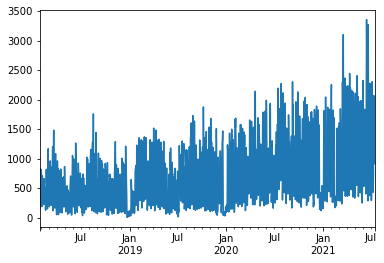

In [9]:
pages.plot()

In [10]:
# Find myself using my ip address
df.loc[df.ip =='75.1.203.41']

,date,time,page_viewed,user_id,cohort_id,ip
2021-03-15 15:28:06,2021-03-15,15:28:06,/,906,137.0,75.1.203.41
2021-03-15 15:35:16,2021-03-15,15:35:16,fundamentals/intro-to-data-science,906,137.0,75.1.203.41
2021-03-15 15:35:17,2021-03-15,15:35:17,fundamentals/modern-data-scientist.jpg,906,137.0,75.1.203.41
2021-03-15 15:35:17,2021-03-15,15:35:17,fundamentals/AI-ML-DL-timeline.jpg,906,137.0,75.1.203.41
2021-03-16 09:13:59,2021-03-16,09:13:59,fundamentals/modern-data-scientist.jpg,906,137.0,75.1.203.41
...,...,...,...,...,...,...
2021-07-12 20:55:44,2021-07-12,20:55:44,appendix/professional-development/interview-qu...,906,137.0,75.1.203.41
2021-07-14 14:30:15,2021-07-14,14:30:15,appendix/professional-development/interview-qu...,906,137.0,75.1.203.41
2021-07-15 10:42:10,2021-07-15,10:42:10,anomaly-detection/continuous-probabilistic-met...,906,137.0,75.1.203.41
2021-07-15 10:53:07,2021-07-15,10:53:07,/,906,137.0,75.1.203.41


## Exponential Moving Average
SMA time series are much less noisy than the time series of the original data points. The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units.

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this:

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where:

M = Number of time periods, span of the window

$t_{0}$ = Latest value

$t-1$ = Previous value

$EMA_{t-1}$ = Exponential moving average of previous day.

The multiplier: $\alpha = \frac{2}{M+1}$

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. So we just need to define the following:

M = span argument = number of time periods. We will try 7 days, 14 days, and 30 days.

Notice how there are no missing values. ewm() will use as many values are available to compute the mean. So if the span is 7 days, but it is on the first day of data available, the EMA will equal the first value.

<AxesSubplot:>

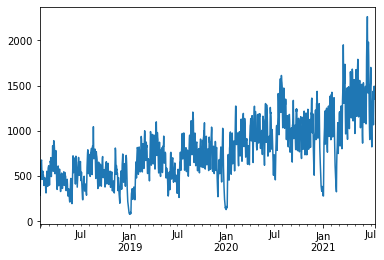

In [11]:
# 7 day EMA
ema_7d = pages.ewm(span = 7).mean()
ema_7d.plot()

<AxesSubplot:>

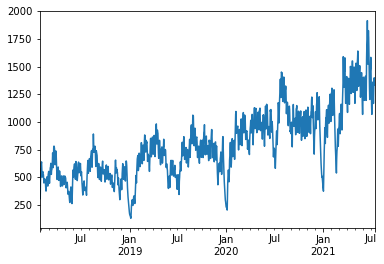

In [12]:
# 14 days EMA
ema_14d = pages.ewm(span = 14).mean()
ema_14d.plot()

In [13]:
# 30 days EMA
ema_30d = pages.ewm(span = 30).mean()

In [14]:
# 90 days EMA
ema_90d = pages.ewm(span = 90).mean()

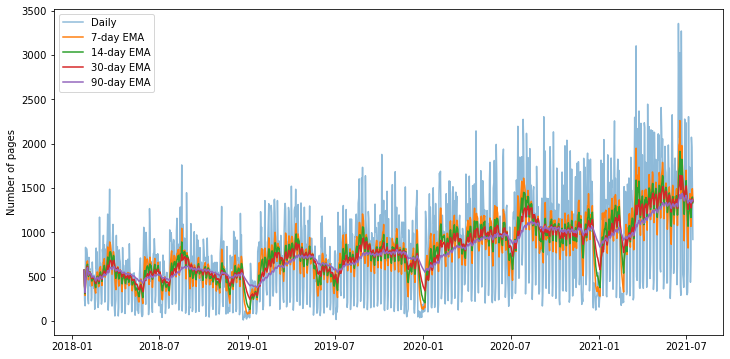

In [15]:
# Plot the 7, 14, 30, 90 day exponential moving averages
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

## Bollinger Bands and %b
Bollinger Bands

- a volatility indicator and commonly used in stock market trading.

- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.

Midband

- The Exponential Moving Average

- midband = train.ewm(span=30).mean()

Upper & Lower Band

- UB/LB = Midband +/- stdev * K

- stdev = train.ewm(span=30).std()

- K = the number of standard deviations to go up and down from the EMA

%b, Percent Bandwidth

- Shows where the last value sits in relation to the bands

- $\%b = \frac{last-LB}{UB-LB}$

- %b > 1 => point lies above UB

- %b < 0 => point lies below LB

- %b == .5 => point lies on the midband.

Bandwidth

- The width of the bands

- $Bandwidth = \frac{(UB-LB)}{Midband}$

In [16]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span = 30).mean()
midband.head()

2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: page_viewed, dtype: float64

In [17]:
# compute exponential moving stdev
std = pages.ewm(span = 30).std()
std.head()

2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: page_viewed, dtype: float64

In [18]:
# compute upper and lower bands
ub = midband + std * 3
lb = midband - std * 3
ub.head()

2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
2018-01-29    1406.405897
2018-01-30    1354.808245
Freq: D, Name: page_viewed, dtype: float64

In [19]:
# concat pages, midband, lb and ub to create a new df 'my_df'

my_df = pd.concat([pages, midband, ub, lb], axis =1)

my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


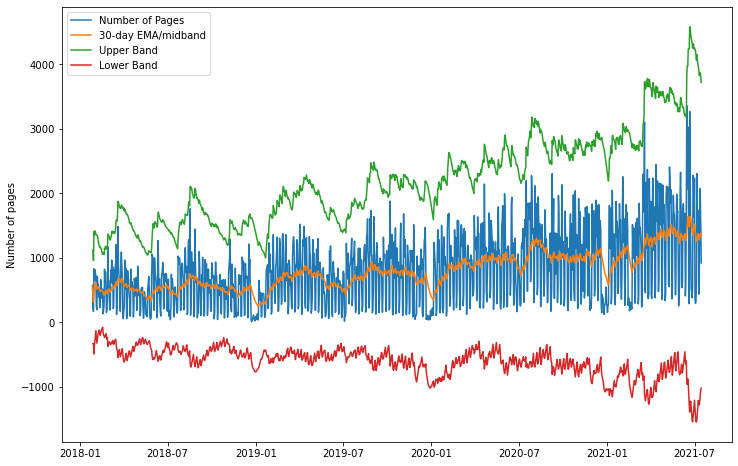

In [20]:
# Plot the bands
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [21]:
# Compute pct_b for each point
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/ (my_df['ub'] - my_df['lb'])
my_df.head()

,pages,midband,ub,lb,pct_b
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


In [22]:
# Search for %b values > 1. No need to search for values < 0 because with this example, a low extreme is not something to be concerned about.
my_df[my_df.pct_b > 1]

,pages,midband,ub,lb,pct_b


In [23]:
# Test on a single user
user = 341
span = 30
weight = 3

anomalies = pd.DataFrame()
user_df = prepare.find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)

In [24]:

anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,


In [26]:
# Loop through all the users
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = prepare.find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [27]:
anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,1
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1
2018-10-15,9,0.581421,8.457414,-7.294571,1.034446,3
2019-01-09,4,0.262470,3.802115,-3.277175,1.027953,3
2019-04-06,2,0.129825,1.889712,-1.630061,1.031334,3
...,...,...,...,...,...,...
2021-06-02,72,10.456225,71.377304,-50.464854,1.005111,925
2021-06-29,32,3.881578,31.571606,-23.808449,1.007736,929
2021-06-11,44,5.582783,43.858655,-32.693089,1.001846,961


In [28]:
# look at value counts for pages in anomalies
anomalies.pages.value_counts(sort = False)

1      56
2      40
3      85
4      87
5      62
       ..
179     1
192     1
198     1
272     1
343     1
Name: pages, Length: 105, dtype: int64

In [29]:
anomalies[anomalies.pages == 343]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2021-06-21,343,22.370564,322.155049,-277.413921,1.034767,804


In [30]:
anomalies[anomalies.user_id == 804]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,


In [31]:

df[df.user_id == 804]

,date,time,page_viewed,user_id,cohort_id,ip
